In [1]:
%load_ext autoreload
%autoreload 2 

# On the previous episode...

On the previous lab we introduced neural network and implemented them using the `PyTorch` library. Our experiments showed that for image classification a CNN architecture yields good results on MNIST and, depending on the complexity of the network you created, "good" results on CIFAR10. However, dealing with MNIST someone might have gotten the wrong impression: "everythings work out-of-the-box or like magic in Deep Learning". Reality is not so rosy and we must go to great lengths do replicate our success on MNIST for other datasets.

In this lab, we will explore common pitfalls as well as common tips and tricks to resolve them. These simple methods will provide superior performance and are very easy to incorporate in our pipeline. 

Specifically, we will talk about:
- Batch Normalization
- Learning rate scheduler
- Residual Connections

In the next lab, we will see more cool "tricks". 

So... let's get started!


In [2]:
# first we load all the necessary libraries
from typing import Optional

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from training_utils import fit, predict, visualize_images, plot_loss

In [3]:
transform = transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/', 
    train=True, 
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/', 
    train=False, 
    download=True,
    transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
# define the hyperparameters
BATCH_SIZE = 256

# find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [5]:
train_dataloader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=False, 
    num_workers=2)


Now, let's visualize some samples.

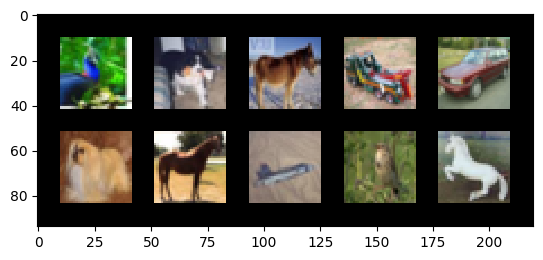

In [6]:
visualize_images(train_dataloader)

At first glance, we can see that this dataset is far more complex than MNIST.

# Batch normalization

We want to learn fast and converge at the same time. If we use a small learning rate, we will converge but it will be too slow. On the other hand, if we use large learning rate, our training will become inconsistent and we will bounce all over the place and never converge. Additionaly, higher learning rates  cause exploding or vanishing gradients i.e. the phenomenon where the multiplication of gradients via the chain rule induces a compound effect on the lower layers, preventing them from learning.

Can we have the best of both worlds? Enter **Batch Normalization**.

1. What does BatchNorm aims to solve? We want to
    * avoid unstable gradients,
    * allow faster learning rates leading to faster convergence,
    * reduce the effect of initialization.

2. Why does BatchNorm actually do?
    * Suppose we are given values of $x$ over a mini-batch $\mathcal{B}=\{x_i\}_{i=1}^m$. Our goal is to learn some parameters $\gamma$ and $\beta$ that perform the proper scaling.

    * First, we compute the mini-batch mean
    $$
    \mu_{\mathcal{B}}=\frac{1}{m}\sum_{i=1}^mx_i
    $$
    * and mini-batch variance
    $$
    \sigma^2_{\mathcal{B}}=\frac{1}{m}\sum_{i=1}^m (x_i-\mu_{\mathcal{B}})^2
    $$
    * we use these quantities to normalize our input
    $$
    \hat{x}_i=\frac{x_i-\mu_{\mathcal{B}}}{\sqrt{\sigma^2_{\mathcal{B}}+\epsilon}}
    $$
    * We scale, shift and return the output
    $$
    y_i=\gamma \hat{x}_i+\beta\equiv \text{BN}_{\gamma, \beta}(x_i)
    $$
    * Essentially, for each mini-batch we normalize the inputs by subtracting their mean and dividing by their standard deviation (estimated based on the statistics of the current mini-batch)  


3. Why does BatchNorm work?

    * BatchNorm is widely used (e.g. the original paper [1] has over 30000 citations). However, the reasons of its success are not perfectly clear.
    * The original authors claim that BatchNorm helps alleviate *Internal Covariate shift*, i.e. the phenomenon of shifting input distributions. Specifically, the input to each layer can be seen as a data distribution that the layer is trying to “learn”. The model, though, does not see the whole dataset but simply mini-batches. If this distribution stays consistent across batches, the layer can "learn effectively".  But, does this happen in practice?
    * the reality is that different mini-batches have different statistics, e.g. mean, variance etc, making the input distribution to the layers jump around. In other words, the input distribuion shifts for every mini-batch. We are trying to learn a "moving target". What if we stabilize it?
    * Batch normalization keeps the input normalized (duh!), preventing them from becoming too large or small and keeping the distribution consistent. 
    
    * It also directly placates the exploding/vanishing gradient problem and  allows higher learning rates.

    * However, other explanations have been proposed. [2] claims that BatchNorm "makes the optimization landscape significantly smoother. This smoothness induces a more predictive and stable behavior of the gradients, allowing for faster training".


---
[1] S. Ioffe and C. Szegedy, “Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift,” in Proceedings of the 32nd International Conference on Machine Learning, Jun. 2015, pp. 448–456. Accessed: Oct. 25, 2021. [Online]. Available: https://proceedings.mlr.press/v37/ioffe15.html

[2] S. Santurkar, D. Tsipras, A. Ilyas, and A. Madry, “How Does Batch Normalization Help Optimization?,” in Advances in Neural Information Processing Systems, 2018, vol. 31. Accessed: Oct. 25, 2021. [Online]. Available: https://papers.nips.cc/paper/2018/hash/905056c1ac1dad141560467e0a99e1cf-Abstract.html



In [7]:
# redo the previous cnn architecture with batch normalization
# where does the batch normalization go?
class CNN_Cifar10(nn.Module): 
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(         
            nn.Conv2d(
                in_channels=3,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding=1,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2), 
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, 
                kernel_size=3, 
                stride=1, 
                padding=1),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),    
        )
              
        # fully connected layer, output 10 classes
        self.out = nn.Linear(2048, 10)       
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) 
        x = self.out(x)
        return x   
        

Epoch 0: Loss=1.9900233186021143
Epoch 1: Loss=1.6124139805229343
Epoch 2: Loss=1.4488603582187576
Epoch 3: Loss=1.3499825955653677
Epoch 4: Loss=1.270187221011337
Epoch 5: Loss=1.19499686177896
Epoch 6: Loss=1.1464681990292607
Epoch 7: Loss=1.1060264329521023
Epoch 8: Loss=1.0552011177856095
Epoch 9: Loss=1.0152345086847032
Epoch 10: Loss=0.9894962931165889
Epoch 11: Loss=0.9627955151455743
Epoch 12: Loss=0.9401969873175329
Epoch 13: Loss=0.9319262644466089
Epoch 14: Loss=0.9038823377721164
Epoch 15: Loss=0.8937369247480315
Epoch 16: Loss=0.8729760336632632
Epoch 17: Loss=0.8565442291449528
Epoch 18: Loss=0.8498380013874599
Epoch 19: Loss=0.8443468945975207
Epoch 20: Loss=0.832022067539546
Epoch 21: Loss=0.8129509918543757
Epoch 22: Loss=0.8038469939207544
Epoch 23: Loss=0.8016348161867687
Epoch 24: Loss=0.7844806915643264
Epoch 25: Loss=0.781223035284451
Epoch 26: Loss=0.7664319954964579
Epoch 27: Loss=0.7563209187011329
Epoch 28: Loss=0.7424573323556355
Epoch 29: Loss=0.741776093536

(0.966285604763031, tensor(68.5500, device='cuda:0'))

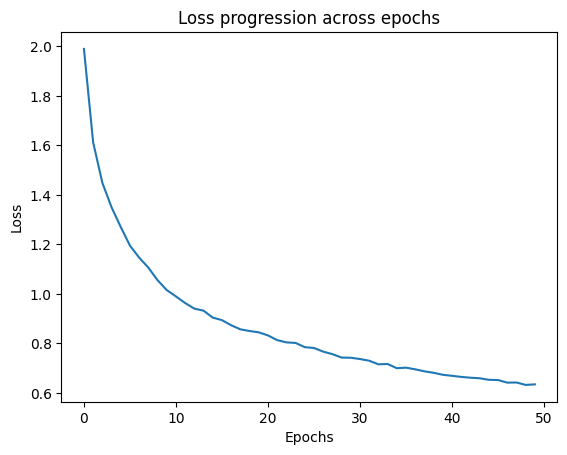

In [8]:
cnn = CNN_Cifar10().to(DEVICE)
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9)

plot_loss(
    fit(
        cnn,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 50,
        device = DEVICE
    )
)

predict(
    cnn,
    test_dataloader = test_dataloader,
    device = DEVICE
)

In [9]:
class CNNwithBN(nn.Module): 
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(         
            nn.Conv2d(
                in_channels=3,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding=1,                  
            ),                              
            nn.ReLU(),   
            nn.BatchNorm2d(16),                   
            nn.MaxPool2d(kernel_size=2), 
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, 
                kernel_size=3, 
                stride=1, 
                padding=1),     
            nn.ReLU(),        
            nn.BatchNorm2d(32),                   
            nn.MaxPool2d(2),    
        )
              
        # fully connected layer, output 10 classes
        self.out = nn.Linear(2048, 10)       
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) 
        x = self.out(x)
        return x   

Epoch 0: Loss=1.405552117800226
Epoch 1: Loss=1.0555200719711733
Epoch 2: Loss=0.9462970972669368
Epoch 3: Loss=0.8807146315063749
Epoch 4: Loss=0.8249214650416861
Epoch 5: Loss=0.7968323413206606
Epoch 6: Loss=0.7625654859810459
Epoch 7: Loss=0.7398276262137354
Epoch 8: Loss=0.7185137913543351
Epoch 9: Loss=0.6976799450966776
Epoch 10: Loss=0.6856958711025666
Epoch 11: Loss=0.6682188396855276
Epoch 12: Loss=0.6545872438927086
Epoch 13: Loss=0.6506911353493223
Epoch 14: Loss=0.6351892078409389
Epoch 15: Loss=0.6256542006621555
Epoch 16: Loss=0.619651989669216
Epoch 17: Loss=0.6093376584503115
Epoch 18: Loss=0.5985752722742607
Epoch 19: Loss=0.5980071049867844
Epoch 20: Loss=0.5893857479095459
Epoch 21: Loss=0.5825447447750033
Epoch 22: Loss=0.5749326190169977
Epoch 23: Loss=0.5646252381254215
Epoch 24: Loss=0.5625413301952031
Epoch 25: Loss=0.5565268204224353
Epoch 26: Loss=0.5565507498626806
Epoch 27: Loss=0.5523776857524502
Epoch 28: Loss=0.5451136345461923
Epoch 29: Loss=0.543607045

(1.2526803077697755, tensor(65.3800, device='cuda:0'))

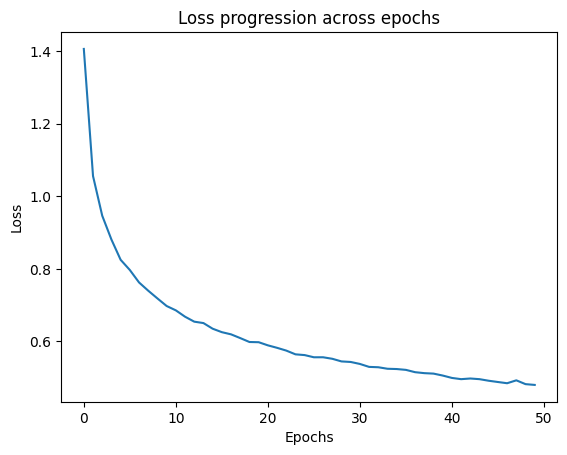

In [10]:
cnn2 = CNNwithBN().to(DEVICE)
optimizer = torch.optim.SGD(cnn2.parameters(), lr=0.01, momentum=0.9)

plot_loss(
    fit(
        cnn2,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 50,
        device = DEVICE
    )
)

predict(
    cnn2,
    test_dataloader = test_dataloader,
    device = DEVICE
)


One of the benefits of Batch Norm is that it allows us to use higher learning rates. Adapt the code above to do so. Does the model learn faster?


Epoch 0: Loss=1.7639656675105193
Epoch 1: Loss=1.301569294564578
Epoch 2: Loss=1.1909019518263486
Epoch 3: Loss=1.1141097512172193
Epoch 4: Loss=1.0580300615758311
Epoch 5: Loss=1.0051207816114232
Epoch 6: Loss=0.9675965585878917
Epoch 7: Loss=0.9414417336181718
Epoch 8: Loss=0.927783228000816
Epoch 9: Loss=0.8968702043805804
Epoch 10: Loss=0.8767096537108324
Epoch 11: Loss=0.8596529093932133
Epoch 12: Loss=0.8490792078023054
Epoch 13: Loss=0.8374322369998816
Epoch 14: Loss=0.829041169614208
Epoch 15: Loss=0.8137876917513049
Epoch 16: Loss=0.7978019407209085
Epoch 17: Loss=0.7886533125930902
Epoch 18: Loss=0.7818168152351769
Epoch 19: Loss=0.7733676865392801
Epoch 20: Loss=0.763997843983222
Epoch 21: Loss=0.754402757603295
Epoch 22: Loss=0.7460231011619374
Epoch 23: Loss=0.7347211591443237
Epoch 24: Loss=0.7250131359513925
Epoch 25: Loss=0.7194954403200928
Epoch 26: Loss=0.7169813839148502
Epoch 27: Loss=0.7172319131846331
Epoch 28: Loss=0.7161363378471258
Epoch 29: Loss=0.698306968929

(1.3477416568756104, tensor(62.2900, device='cuda:0'))

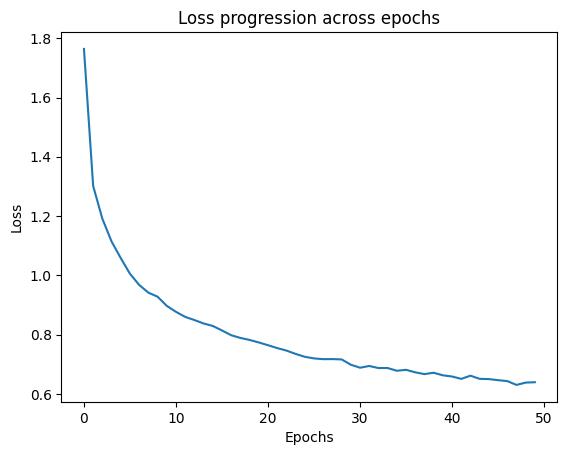

In [11]:
cnn2 = CNNwithBN().to(DEVICE)
optimizer = torch.optim.SGD(cnn2.parameters(), lr=0.05, momentum=0.9)

plot_loss(
    fit(
        cnn2,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 50,
        device = DEVICE
    )
)


predict(
    cnn2,
    test_dataloader = test_dataloader,
    device = DEVICE
)

## Learning rate scheduler

We have just seen that batch normalization allows, in this case, for a quicker improvement with a higher learning rate. Still, the loss plateaus quickly and me start seeing minimal improvement. This is often due to the optimization algorithm overshooting the gradient descent.

Can we reduce the step size on the go? Yes! :smiley: This is what learning schedulers are for. The idea is simple: instead of a constant learning rate, we reduce it based on some conditions, or after a certain amount of steps.

Two common schedulers are [`MultiStepLR`][MultiStepLR] and [`ReduceLROnPlateau`][ReduceLROnPlateau]. The first one, simply multiplies our learning rate `lr` by a constant factor $\gamma < 1$ after some predefined number of steps. For instance, if the initial learning rate is `lr=1`, and we set $\gamma=0.5$ for "milestones" of 20 and 50, then the optimizer is going to use `lr=1` for the first 20 epochs, then `lr=0.5` for the subsequent 30, and finally `lr=0.25` for all the remaining ones.

`ReduceLROnPlateau` tracks a given metric, e.g. validation loss or accuracy, and reduces the learning rate if no improvement is seen after a predefined number of steps, called "patience".

[MultiStepLR]: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html
[ReduceLROnPlateau]: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html

In the following cell, augment the `fit` function from previous weeks (in `training_utils.py`) to accept a scheduler argument and use it while training

In [12]:
from training_utils import train_epoch

def fit_scheduler(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None
):
    """
    the fit method simply calls the train_epoch() method for a
    specified number of epochs.
    """

    # keep track of the losses in order to visualize them later
    losses = []
    for epoch in range(epochs):
        running_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device,
        )
        print(f"Epoch {epoch}: Loss={running_loss}")
        losses.append(running_loss)

        if scheduler is not None:
            scheduler.step()

    return losses


Now train again the batch-norm-cnn, using the `MultiStepLR` scheduler.

Epoch 0: Loss=1.68893989798974
Epoch 1: Loss=1.2718623012912518
Epoch 2: Loss=1.1606835434023215
Epoch 3: Loss=1.07944371079912
Epoch 4: Loss=1.0254512280225754
Epoch 5: Loss=0.9899466922696756
Epoch 6: Loss=0.9596664239557422
Epoch 7: Loss=0.9305090916400053
Epoch 8: Loss=0.901073264528294
Epoch 9: Loss=0.8834499750210314
Epoch 10: Loss=0.8661960238704876
Epoch 11: Loss=0.8427257233736466
Epoch 12: Loss=0.8255730389940495
Epoch 13: Loss=0.8153836322682244
Epoch 14: Loss=0.8019020806769935
Epoch 15: Loss=0.8007955219672651
Epoch 16: Loss=0.7809041708099599
Epoch 17: Loss=0.7769880477263003
Epoch 18: Loss=0.7639205598709534
Epoch 19: Loss=0.7627694025939825
Epoch 20: Loss=0.7581354349243398
Epoch 21: Loss=0.7391593988452639
Epoch 22: Loss=0.7311924273262218
Epoch 23: Loss=0.7280483756746564
Epoch 24: Loss=0.7223563060468557
Epoch 25: Loss=0.7130905094803596
Epoch 26: Loss=0.719431187425341
Epoch 27: Loss=0.702545551621184
Epoch 28: Loss=0.7007681891626242
Epoch 29: Loss=0.70076777801221

(1.06989859790802, tensor(68.1100, device='cuda:0'))

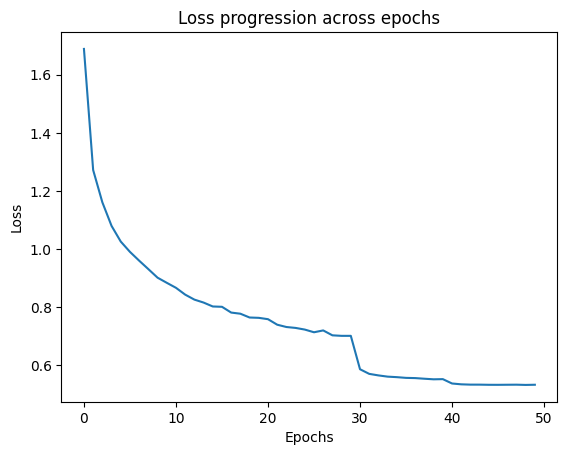

In [13]:
cnn2 = CNNwithBN().to(DEVICE)
optimizer = torch.optim.SGD(cnn2.parameters(), lr=0.05, momentum=0.9)

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[30, 40],
    gamma=0.1,
)

plot_loss(
    fit_scheduler(
        cnn2,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 50,
        device = DEVICE,
        scheduler=scheduler,
    )
)

predict(
    cnn2,
    test_dataloader = test_dataloader,
    device = DEVICE
)


# Residual connections

As neural networks go deeper, they are able to construct complex representations and yield superior performance. However, we cannot simply stack as many layers as we want to increase the depth. 

![caption](media/resnet-no-skip-horizontal.png)

This is due to the **vanishing gradient** problem. Specifically, backpropagating the gradient to earlier layers involves repeated multiplication (with small values) rendering the gradient extremely small. This effectively means that as we go deeper, performance gets saturated. Instead of improved performance we even have degradation!

How can we reconcile this tradeoff? On the one hand, we want to increase depth but on the other hand this hurts convergence. 

Enter **skip connections** [3]! The network of the previous figure now becomes the following:

![caption](media/resnet-horizontal.png)

Now, let's think why these skip connections work. First, they allow the gradient to flow via this shortcut connection, which helps mitigate the problem of vanishing gradient. Second, they allow the model to learn the identity function. In other words, this ensures that the higher layer will perform at least as good as the lower layer.

---
[3] K. He, X. Zhang, S. Ren, and J. Sun, “Deep Residual Learning for Image Recognition,” in 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, USA, Jun. 2016, pp. 770–778. doi: 10.1109/CVPR.2016.90.



First, we build the network of the first image, i.e. with no skip connections. The Resnet depicted above is characterized by an interesting pattern. It consists of "super-blocks" (see the different colors) and each one consists of two blocks that start after one residual connection and finish just before one. Notice that each color is associated with a different number, i.e. 64, 128, 256, 512. 

We will build a `nn.Module` for each block and repeat it to create the super-blocks and by extension the whole architecture.

The ResNet depicted above is meant to be used for `ImageNet`, a more complex dataset compared to `CIFAR10`. For computational considerations, we amend our implementation and make a simpler version.

In [14]:
class WrongBlock(nn.Module):
    
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels = in_planes,
            out_channels = planes, 
            kernel_size=3, 
            stride=stride, 
            padding=1, 
            bias=False)

        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, 
            planes, 
            kernel_size=3,
            stride=1, 
            padding=1, 
            bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        return x


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes 
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



Epoch 0: Loss=1.9426689750077772
Epoch 1: Loss=1.6020760870709712
Epoch 2: Loss=1.393186243212953
Epoch 3: Loss=1.1838061614912383
Epoch 4: Loss=0.9966222932752298
Epoch 5: Loss=0.8523099693108578
Epoch 6: Loss=0.7649139666131565
Epoch 7: Loss=0.688080965864415
Epoch 8: Loss=0.6135943136653121
Epoch 9: Loss=0.5555470216335082
Epoch 10: Loss=0.5066240472452981
Epoch 11: Loss=0.45545256107437365
Epoch 12: Loss=0.4114627237526738
Epoch 13: Loss=0.3694821451695598
Epoch 14: Loss=0.3283362674469851
Epoch 15: Loss=0.30527687566925066
Epoch 16: Loss=0.263866586876767
Epoch 17: Loss=0.22760634215510622
Epoch 18: Loss=0.20353565806028795
Epoch 19: Loss=0.17920629174581595
Epoch 20: Loss=0.1585009434659566
Epoch 21: Loss=0.1387685167090017
Epoch 22: Loss=0.11875114614638138
Epoch 23: Loss=0.10850031054293623
Epoch 24: Loss=0.09299601295164653
Epoch 25: Loss=0.09734820783594433
Epoch 26: Loss=0.07045778079072432
Epoch 27: Loss=0.06684174989730272
Epoch 28: Loss=0.07240652134261873
Epoch 29: Loss=

(1.0633700326919555, tensor(79.1000, device='cuda:0'))

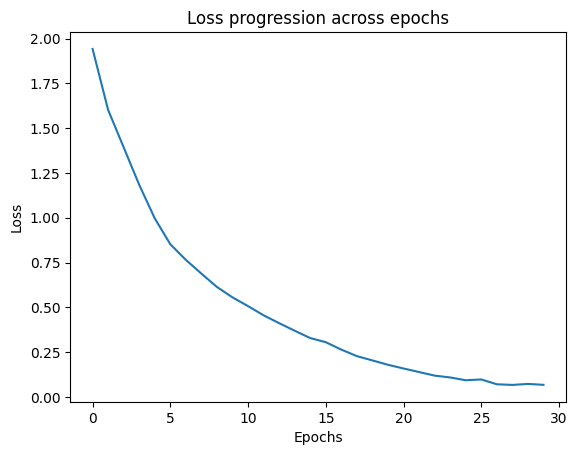

In [15]:
# initialize the model 
model = ResNet(block=WrongBlock, num_blocks=[2,2,2,2]).to(DEVICE)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# train the ResNet
plot_loss(
    fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 30,
        device = DEVICE
    )
)

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)


How many layers does the above model have?

Now, we add skip connections. Notice that sometimes the skip connection cannot be simply an identity function, since the dimensions will not match. Identify the condition when this is necessary. In that case, the shortcut function should be a convolution followed by BatchNorm. 

Fill the code below!

In [16]:

class CorrectBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out


Epoch 0: Loss=1.8323216280158685
Epoch 1: Loss=1.2661957661716305
Epoch 2: Loss=0.9773778158183001
Epoch 3: Loss=0.7860835285819306
Epoch 4: Loss=0.6292840868842845
Epoch 5: Loss=0.5089952536687559
Epoch 6: Loss=0.3954836213771178
Epoch 7: Loss=0.3006728695971625
Epoch 8: Loss=0.21470572103803254
Epoch 9: Loss=0.15939191671810587
Epoch 10: Loss=0.11894431883203131
Epoch 11: Loss=0.08396885294125092
Epoch 12: Loss=0.07813337052773152
Epoch 13: Loss=0.05727800562008455
Epoch 14: Loss=0.05289009371202211
Epoch 15: Loss=0.048218002823200455
Epoch 16: Loss=0.05183957297621029
Epoch 17: Loss=0.039144470738912265
Epoch 18: Loss=0.03769769058657848
Epoch 19: Loss=0.03939305886635747
Epoch 20: Loss=0.03884056432419741
Epoch 21: Loss=0.029750759852337366
Epoch 22: Loss=0.03134617511876764
Epoch 23: Loss=0.037935330431518734
Epoch 24: Loss=0.03505045173889292
Epoch 25: Loss=0.02279741854326115
Epoch 26: Loss=0.025917346534623326
Epoch 27: Loss=0.034905783950864355
Epoch 28: Loss=0.020299554616569

(1.351462601852417, tensor(77.2700, device='cuda:0'))

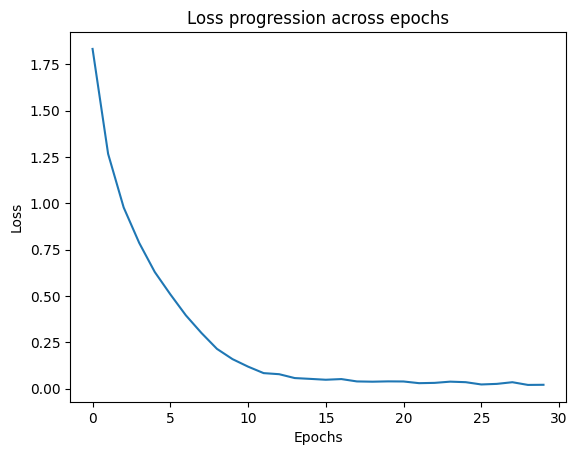

In [17]:
# initialize the model 
model = ResNet(block=CorrectBlock, num_blocks=[2,2,2,2]).to(DEVICE)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# train the ResNet
plot_loss(
    fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 30,
        device = DEVICE
    )
)

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)


**Question:** It looks like the model without the residual connections performs better (~2%), but on a closer examination of the training curves the residual model achieves lower loss much faster and then plateaus. You might try to add a scheduler to boost the performance!